# Sentiment Analysis mit traditionellen Machine Learning Modellen 

Im Folgenden nutzen wir traditionelle Modelle zur Klassifizierung von Sentiments.  
  
Dafür haben wir mit diversen Machine Learning Algorithmen experimentiert.
Die drei besten Algorithmen betrachten wir genauer:   
- Multinomial Naive Bayes
- Logistische Regression
- LSVM

Desweiteren haben wir die Features auf zwei unterschiedliche Arten erstellt und diese Ansätze ebenfalls miteinander verglichen: 
- Bag-of-Words (BOW)
- Term Frequency Inverse Document Frequency (TFIDF)

Sowohl BoW als auch TFIDF haben wir mit verschiedenen N-Grams angewandt um die Ergebnisse miteinander zu vergleichen.  
Dafür haben wir Unigrams, Bigrams sowie Trigrams verwendet. 
  
Dieses Vorgehen haben wir auf zwei unterschiedlichen Datensätzen angewandt:   
- Movie Revies: kleineres Data-Set, was  3 Klassen enthält (-1: negativ, 0: neutral, 1: positiv)  
- Twetts: größeres Datenset, was 2 Klassen enthält (-1: negativ, 1: positiv)  

Abschließend haben wir die Accuracys in Tabellen miteinander verglichen 

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import sklearn
import nltk
import re
import csv
from evaluation import test_statistics
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt  



In [2]:
%cd Documents/LSC/LSC_Sentiment_Analysis/

[WinError 3] Das System kann den angegebenen Pfad nicht finden: 'Documents/LSC/LSC_Sentiment_Analysis/'
c:\Users\Dell\OneDrive\Desktop\Uni\Semester 2\Ökonometrie\GitHub\LSC_Sentiment_Analysis


## Movie Reviews (kleineres Daten-Set)
- 8088 Samples (nach Balancing)
- 3 Klassen: -1: negativ, 0: neutral, 1: positiv

In [23]:
#%cd ..

## 1. Data Loading

Wir laden den Datensatz, den wir zuvor im Notebook "ExploratoryDataAnalysis" aufbereitet und balanciert haben.


In [3]:
train_set = pd.read_csv ("./data/dataset_mr/Trainset_complete.csv", sep = ';')
test_set = pd.read_csv ("./data/dataset_mr/Testset.csv", sep = ';')

In [4]:
# balancierte Daten
train_set.Sentiment.value_counts()

 1    2696
 0    2696
-1    2696
Name: Sentiment, dtype: int64

## 2. Data cleaning

Die Daten haben wir durch folgendes Vorgehen bereinigt: 
- alle Zeichen, die keine Buchstaben sind, rausgelöscht. Für die Sentinemt Analyse spielen nur Wörter eine Rolle. Ziffern oder Sonderzeichen liefern keinen großen Mehrwert.
- alle Buchstaben auf Kleinschreibung angepasst. So wird z.B: "Amazing" und "amazing" nicht als zwei unterschiedliche Wörter gezählt.
- Stop-Words herauslöschen. Wir gehen davon aus, dass das bloße Vorhandensein von  Wörtern wie 'and' 'or' 'a' 'she' usw. keinen großen Mehrwert für die Sentimentanalyse liefert
Wir haben die vordefinierten Stop-Words von Natural Language Toolkit (nltk) verwendet, welches 179 Wörter enthält, die sehr häufig in der englischen Sprache vorkommen
- Stemming: Wortendungen abschneiden, sodass nur der Wortstamm übrig bleibt. Hierzu verwenden wir den Porter-Stemmer-Algorithmus. 

Anschließend wenden wir die definierten Funktionen sowohl auf unser Trainings- als auch auf unser Testset an. 

In [5]:
# Nur Buchstaben behalten. Alle anderen Zeichen rauslöschen  
def keep_only_letters(text):
    text=re.sub(r'[^a-zA-Z\s]','',text)
    return text
 
# alle Buchstaben auf Kleinschreibung ändern
def convert_to_lowercase(text):
    return text.lower()
 
def clean_reviews(text):
    text = keep_only_letters(text)
    text = convert_to_lowercase(text)
    return text


# Stop Words definition
english_stop_words = nltk.corpus.stopwords.words('english')
print(len(english_stop_words))
print (english_stop_words[:20])

# Stop Words entfernen 
def remove_stop_words(text):
    for stopword in english_stop_words:
        stopword = ' ' + stopword + ' '
        text = text.replace(stopword, ' ')
    return text


# Stemming mit Porter-Stemmer-Algorithmus 
def text_stemming(text):
    stemmer = nltk.porter.PorterStemmer()
    stemmed = ' '.join([stemmer.stem(token) for token in text.split()])
    return stemmed


train_set['Phrase'] = train_set['Phrase'].apply(clean_reviews)
test_set['Phrase'] = test_set['Phrase'].apply(clean_reviews)

train_set['Phrase'] = train_set['Phrase'].apply(remove_stop_words)
test_set['Phrase'] = test_set['Phrase'].apply(remove_stop_words)

train_set['Phrase'] = train_set['Phrase'].apply(text_stemming) 
test_set['Phrase'] = test_set['Phrase'].apply(text_stemming)

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


## 3. Text Vectorization
In diesem Schritt wandeln wir unsere Daten in numerische Form um und erstellen so unsere Features. 
Dabei werden die Reviews in eine Matrix aus token counts umgewandelt.  
Der Vektorizer wird dabei an die Trainingsdaten angepasst. Die Anzahl der Features entspricht somit der Anzahl der Token, die im Trainings-Set enthalten sind.  
Dieses Vokabular verwenden wir anschließend ebenfalls zur Transformation des Test-Sets.  
Token, die nur im Test-Set auftauchen, werden von dem Modell also nicht berücksichtigt. Die Test-Daten sollen zunächst für das Modell verborgen bleiben.   
Zudem kann ein Token, das nicht in den Trainingsdaten enthalten ist, nicht gelernt werden und liefert somit keinen Mehrwert für die Vorhersage.   

Wir erstellen die Features auf zwei verschiedene Arten um sie nachher bzgl. ihrer Accuracy zu vergleichen. 
- Bag-of-Words (BOW) -> Dafür nutzen wir den CountVectorizer mit dem Parameter binary=False, sodass die Häufigkeit der Token berücksichtigt wird und nicht nur das Vorhandensein (1:ja, 0:nein)  
- Term Frequency Inverse Document Frequency (TFIDF) -> dafür nutzen wir den TfidfVectorizer mit dem Parameter use_idf=True, sodass die inverse document frequency berücksichtigt wird

Beim Bow Ansatz werden ausschließlich das Vokabluar von Wörtern, sowie die Häufigkeit eines Wortes pro Dokument berücksichtigt -> term frequency. 

Bei der Bestimmung von TFIDF Features berücksichtigen wir neben der term-frequency zusätzlich die inverse document frequency.
Diese untersucht das Vorhandensein eines Tokens in allen Dokumenten.  
Ein Token, der in wenigen Dokumenten vorkommt, bekommt es einen höheren IDF-Wert.  
Ein Token, der in den meisten Dokumenten vorkommt, erhält dagegen einen geringeren IDF-Wert.  
So können seltene Wörter hervorgehoben werden und häufige Wörter, die einen geringen Mehrwert bieten, bekommen ein penalty.  
Der TF-IDF errechnet sich anschließend als das Produkt aus der term-frequency und der inverse document frequency.


### N-Grams
Mit N-Grams können wir vorgeben, ob der Bag-of-Words bzw. TGIDF Algorithmus nur einzelne Wörter oder auch aufeinanderfolgende Wörter berücksichtigt
- Unigram: Alle eindeutigen Wörter in einem Dokument
- BiGram: Alle Permutationen von zwei aufeinanderfolgenden Wörtern in einem Dokument
- TriGram: Alle Permutationen von drei aufeinanderfolgenden Wörtern in einem Dokument

Nach Vextorization:  
Jeder Token im Vokabular wird durch eine Spalte im Datensatz repräsentiert.
Für jedes Review im Datensatz wird die Frequency der Token (term-frequency) dargestellt.

In [6]:
# Text Datne in numerische Daten umwandeln

# Argument binary=False: Vocabel-Vector mit term-frequency füllen
# binary = True: Vocabel-Vector mit Vorhandensein der Token füllen (1 vorhanden, 0 nicht vorhanden) 
# ngram _range = Unigram: (1,1); Bigram: (1,2); Trigram: (1,3)

# Vectorizer für Bag-of-Word
# Unigram
vectorizer_uni_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))
# Bigram
vectorizer_bi_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,2))
# Trigram
vectorizer_tri_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,3))

In [7]:
# Vectorizer für TGIDF
# Unigram
vectorizer_uni_tgidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,1))
# Bigram
vectorizer_bi_tgidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,2))
# Trigram
vectorizer_tri_tgidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,3))

In [8]:
# Vectorizer auf das Train-Set fitten und damit Train- und Test-Set transformieren - BoW

uni_train_bow = vectorizer_uni_bow.fit_transform(train_set['Phrase'])
uni_test_bow = vectorizer_uni_bow.transform(test_set['Phrase'])

bi_train_bow = vectorizer_bi_bow.fit_transform(train_set['Phrase'])
bi_test_bow = vectorizer_bi_bow.transform(test_set['Phrase'])

tri_train_bow = vectorizer_tri_bow.fit_transform(train_set['Phrase'])
tri_test_bow = vectorizer_tri_bow.transform(test_set['Phrase'])

In [9]:
# Vectorizer auf das Train-Set fitten und damit Train- und Test-Set transformieren - TGIDF

uni_train_tgidf = vectorizer_uni_tgidf.fit_transform(train_set['Phrase'])
uni_test_tgidf = vectorizer_uni_tgidf.transform(test_set['Phrase'])

bi_train_tgidf = vectorizer_bi_tgidf.fit_transform(train_set['Phrase'])
bi_test_tgidf= vectorizer_bi_tgidf.transform(test_set['Phrase'])

tri_train_tgidf = vectorizer_tri_tgidf.fit_transform(train_set['Phrase'])
tri_test_tgidf = vectorizer_tri_tgidf.transform(test_set['Phrase'])

In [10]:
train_labels = train_set['Sentiment']
test_labels = test_set['Sentiment']

## 4. Klassifizierungsmodelle trainieren

für die Klassifizierung trainieren wir zunächst diverse Modelle, die wir anhand ihrer Accuracy miteinander vergleichen.  
Im ersten Schritt trainieren wir nur mit den Uni-gram Bag of Words, um einen ersten Eindruck zu bekommen, welche Modelle sich am besten für unsere Sentiment Analyse eigenen.  
Die folgenden drei Modelle erreichten dabei die beste Accuracy: 

- Naive Bayes  
- Logistische Regression  
- Linear Support Vector Machines (LSVM)

Diese wollen wir im weiteren Verlauf genauer betrachten. 
Dafür geben wir nacheinander die Unigrams, Bigrams und Trigrams in die Modelle, sodass wir die Accuracy vergleichen können.  
Dieses Vorgehenn machen wir erst mit dem BoW Ansatz und anschließend mit TFIDF. Am Ende vergleichen wir alle Accuracys miteinander, um den besten Ansatz zu finden 

In [100]:
from sklearn import metrics
from sklearn.utils.extmath import density
from time import time

def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(tri_train_tgidf, train_labels)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(tri_test_tgidf)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    score = metrics.accuracy_score(test_labels, pred)
    print(f"accuracy:   {score:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score, train_time, test_time

In [101]:
# diverse Modelle testen, die 3 mit bester Accuracy verfolgen wir weiter

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC

results = []
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    # L2 penalty Linear SVC
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
   
    # NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "NearestCentroid"),
    # naive Bayes classifier
    (MultinomialNB(), "Multinomial naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=5, max_iter=1000)
train time: 9.17s
test time:  0.004s
accuracy:   0.534
dimensionality: 109529
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=100)
train time: 0.00491s
test time:  1.18s
accuracy:   0.505

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 1.75e+02s
test time:  0.192s
accuracy:   0.488

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC(C=0.1, dual=False)
train time: 0.343s
test time:  0.0s
accuracy:   0.524
dimensionality: 109529
density: 1.0


NearestCentroid
________________________________________________________________________________
Training: 
NearestCentroid()
train time: 0.0106s
tes

### 4.1.  Naive Bayes

Der Naive Bayes Klassifizierer sagt das Label einer neuen Beobachtung voraus, indem er die Wahrscheinlichkeiten für alle möglichen Zustände dieser Variablen berechnet und den Zustand mit der höchsten Wahrscheinlichkeit vorhersagt. In diesem Fall gibt es drei mögliche Zustände: positive, neutrale oder negative Bewertung.  
  
Zunächst wird für die drei Zustände der Prior berechnet: Wie wahrscheinlich ist das Auftreten des Zustandes an sich.  
Da wir mit balancierten Daten arbeiten, ist der Prior für jede der drei Klassen: 0,33333 
  
Anschließend werden die bedingten Wahrscheinlichkeiten (Conditional Likelihoods) berechnet:  
Wahrscheinlichkeit, dass Wort n vorkommt, unter der Bedingung, dass es z.B. eine positive Bewertung ist.  
Die Conditional Likelihoods für jedes Wort in der Bewertung werden miteinander sowie mit dem jeweiligen Prior der Klasse multipliziert.  
Diese Berechnung wird für jede mögliche Klasse durchgeführt.  
Anschließend wird die Klasse mit der höchsten Wahrscheinlichkeit angenommen.  
  
Vorteile:
- Naive Bayes benötigt keine kontinuierlichen Werte, wir könnten auch mit den Labels "negativ", "neutral", "positiv" trainieren  
(da wir das Preprocessing einheitlich für alle Modelle vorgenommen haben, arbeiten wir mit kontinuierlichen Werten)
- Algorithmus ist sehr einfach und schnell zu trainieren
  
Nachteile:
- Nur Labels funktionieren als Input, was für uns aber kein Problem dartellt, da wir ohnehin Labels als Input haben 
- Naive Annahme:  
Dem Naive Bayes Klassifizierer liegt die Annahme zugrunde, dass es keine Abhängigkeiten zwischen den Features gibt.  
Diese Annahme wird in der Praxis fast immer verletzt, so wie auch in diesem Fall. Bestimmte Wörter werden häufiger zusammen benutzt.  
Kommt zum Beipiel das Word "lustig" in einem Satz vor, ist es wahrscheinlicher, dass auch das Wort "lachen" darin vorkommt.  
  
Trotzdem liefert der Naive Bayes KLassifizierer interessante Informationen. 

#### 4.1.1. Naive Bayes: Unigram (Naive Bayes Klassifizierer auf Unigram Features)

##### 4.1.1.1 Bag-of-Words

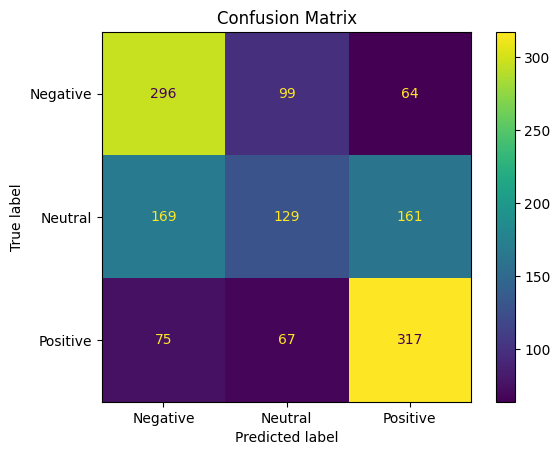

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.64      0.59       459
     Neutral       0.44      0.28      0.34       459
    Positive       0.58      0.69      0.63       459

    accuracy                           0.54      1377
   macro avg       0.52      0.54      0.52      1377
weighted avg       0.52      0.54      0.52      1377



In [11]:
#TODO : Funktioniert noch nicht
uni_nb = MultinomialNB()
uni_nb.fit(uni_train_bow, train_labels)
 
predictions = uni_nb.predict(uni_test_bow)

acc_nb_uni_bow = test_statistics(predictions, test_labels)
#print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))


##### 4.1.1.2 TGIDF

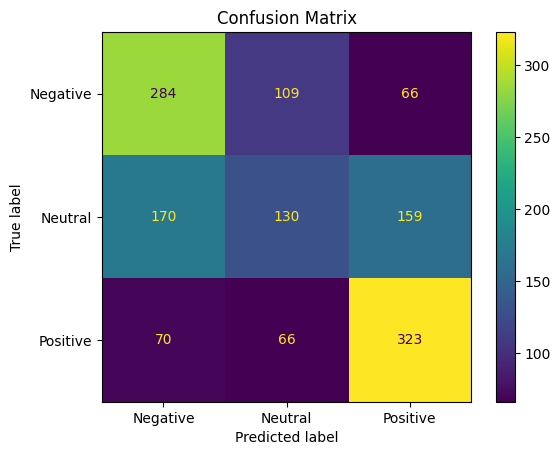

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.62      0.58       459
     Neutral       0.43      0.28      0.34       459
    Positive       0.59      0.70      0.64       459

    accuracy                           0.54      1377
   macro avg       0.52      0.54      0.52      1377
weighted avg       0.52      0.54      0.52      1377



In [12]:
uni_nb = MultinomialNB()
uni_nb.fit(uni_train_tgidf, train_labels)
 
predictions = uni_nb.predict(uni_test_tgidf)

acc_nb_uni_tg = test_statistics(predictions, test_labels)

In [13]:
# blaue Confusion Matrix:
"""import seaborn as sns
import matplotlib.pyplot as plt  

co_ma = sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[-1, 0, 1])   

ax= plt.subplot()
sns.heatmap(co_ma, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation
sns.set (rc = {'figure.figsize':(5, 4)})
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['-1', '0','1']); ax.yaxis.set_ticklabels(['-1', '0','1'])"""

"import seaborn as sns\nimport matplotlib.pyplot as plt  \n\nco_ma = sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[-1, 0, 1])   \n\nax= plt.subplot()\nsns.heatmap(co_ma, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation\nsns.set (rc = {'figure.figsize':(5, 4)})\n# labels, title and ticks\nax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); \nax.set_title('Confusion Matrix'); \nax.xaxis.set_ticklabels(['-1', '0','1']); ax.yaxis.set_ticklabels(['-1', '0','1'])"

#### 4.1.2 Naive Bayes: Unigram + Bigram

##### 4.1.2.1 Bag-of-Words

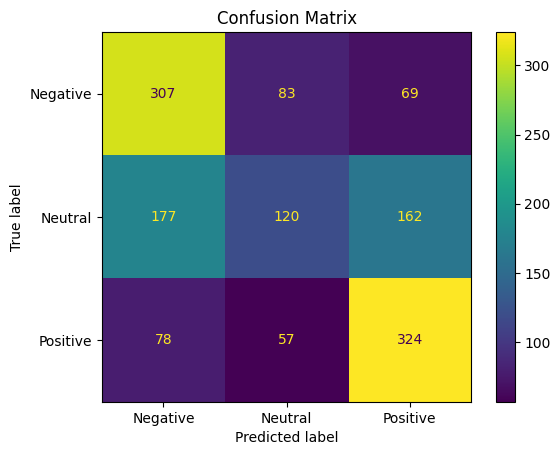

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.67      0.60       459
     Neutral       0.46      0.26      0.33       459
    Positive       0.58      0.71      0.64       459

    accuracy                           0.55      1377
   macro avg       0.53      0.55      0.52      1377
weighted avg       0.53      0.55      0.52      1377



In [13]:
bi_nb = MultinomialNB()
bi_nb.fit(bi_train_bow, train_labels)
 
predictions = bi_nb.predict(bi_test_bow)
acc_nb_bi_bow = test_statistics(predictions, test_labels)


##### 4.1.2.2 TGIDF

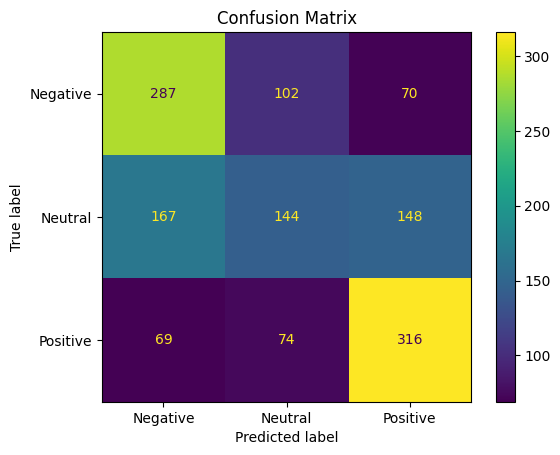

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.63      0.58       459
     Neutral       0.45      0.31      0.37       459
    Positive       0.59      0.69      0.64       459

    accuracy                           0.54      1377
   macro avg       0.53      0.54      0.53      1377
weighted avg       0.53      0.54      0.53      1377



In [14]:
bi_nb = MultinomialNB()
bi_nb.fit(bi_train_tgidf, train_labels)
 
predictions = bi_nb.predict(bi_test_tgidf)
acc_nb_bi_tg = test_statistics(predictions, test_labels)

#### 4.1.3 Naive Bayes: Unigram + Bigram + Trigram

##### 4.1.3.1 Bag-of-Words

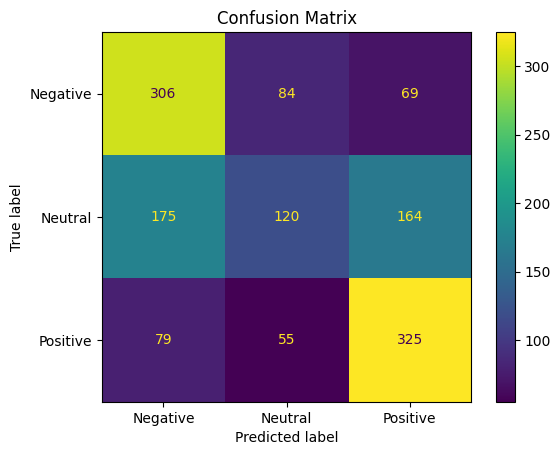

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.67      0.60       459
     Neutral       0.46      0.26      0.33       459
    Positive       0.58      0.71      0.64       459

    accuracy                           0.55      1377
   macro avg       0.53      0.55      0.52      1377
weighted avg       0.53      0.55      0.52      1377



In [15]:
tri_nb = MultinomialNB()
tri_nb.fit(tri_train_bow, train_labels)
 
predictions = tri_nb.predict(tri_test_bow)
acc_nb_tri_bow = test_statistics(predictions, test_labels)


##### 4.1.3.2 TGIDF

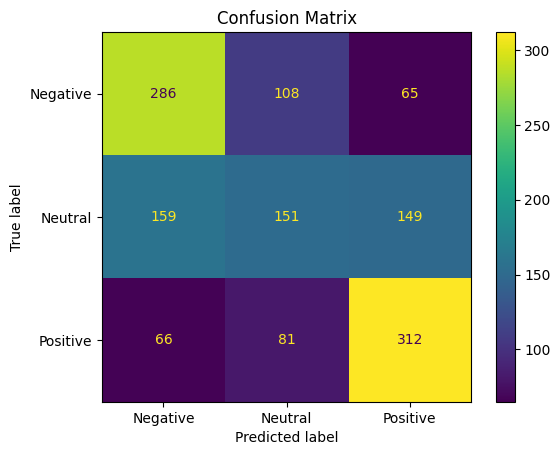

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.56      0.62      0.59       459
     Neutral       0.44      0.33      0.38       459
    Positive       0.59      0.68      0.63       459

    accuracy                           0.54      1377
   macro avg       0.53      0.54      0.53      1377
weighted avg       0.53      0.54      0.53      1377



In [16]:
tri_nb = MultinomialNB()
tri_nb.fit(tri_train_tgidf, train_labels)
 
predictions = tri_nb.predict(tri_test_tgidf)
acc_nb_tri_tg = test_statistics(predictions, test_labels)

### 4.2 Logistische Regression
#### 4.2.1. Unigram

##### 4.2.1.1 Bag-of-Words

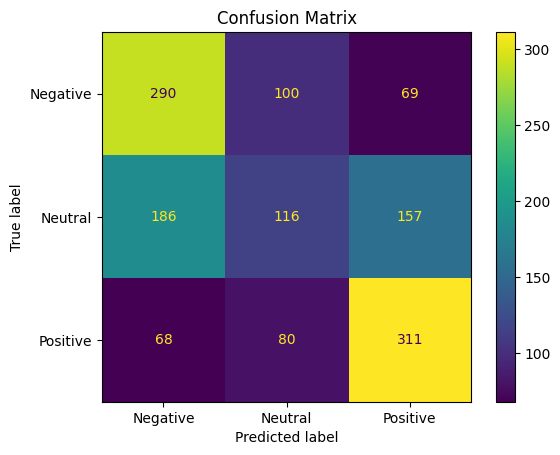

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.53      0.63      0.58       459
     Neutral       0.39      0.25      0.31       459
    Positive       0.58      0.68      0.62       459

    accuracy                           0.52      1377
   macro avg       0.50      0.52      0.50      1377
weighted avg       0.50      0.52      0.50      1377



In [17]:
uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
uni_logreg.fit(uni_train_bow, train_labels)

predictions = uni_logreg.predict(uni_test_bow)
acc_lr_uni_bow = test_statistics(predictions, test_labels)


##### 4.2.1.2 TGIDF

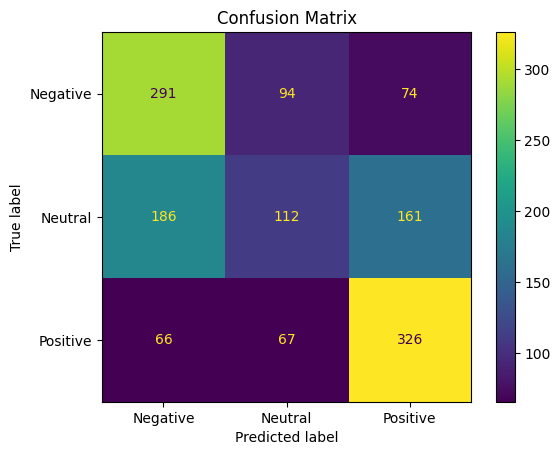

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.63      0.58       459
     Neutral       0.41      0.24      0.31       459
    Positive       0.58      0.71      0.64       459

    accuracy                           0.53      1377
   macro avg       0.51      0.53      0.51      1377
weighted avg       0.51      0.53      0.51      1377



In [18]:
uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
uni_logreg.fit(uni_train_tgidf, train_labels)
 
predictions = uni_logreg.predict(uni_test_tgidf)
acc_lr_uni_tg = test_statistics(predictions, test_labels)

#### 4.2.2. Log Regression: Unigrams + Bigrams

##### 4.2.2.1 Bag-of-Words

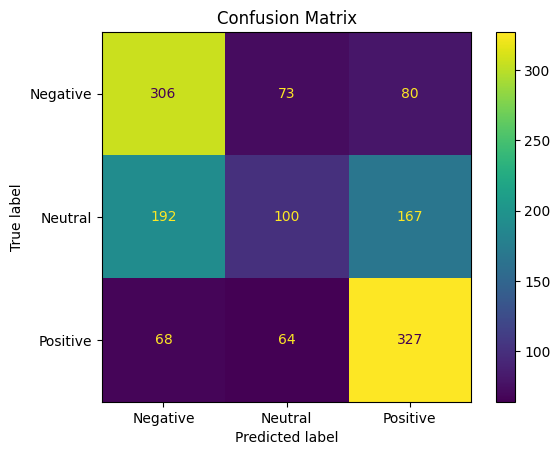

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.67      0.60       459
     Neutral       0.42      0.22      0.29       459
    Positive       0.57      0.71      0.63       459

    accuracy                           0.53      1377
   macro avg       0.51      0.53      0.51      1377
weighted avg       0.51      0.53      0.51      1377



In [19]:
bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
bi_logreg.fit(bi_train_bow, train_labels)

predictions = bi_logreg.predict(bi_test_bow)
acc_lr_bi_bow = test_statistics(predictions, test_labels)
# Feature-Set Größe erhöht sich weil auch Bi-Gramme berücksichtigt 

##### 4.2.2.2 TGIDF

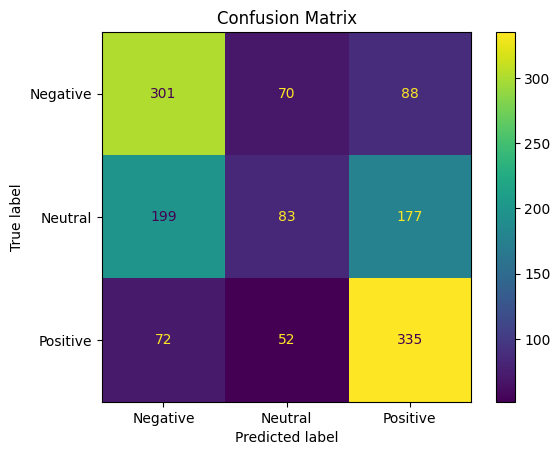

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.53      0.66      0.58       459
     Neutral       0.40      0.18      0.25       459
    Positive       0.56      0.73      0.63       459

    accuracy                           0.52      1377
   macro avg       0.50      0.52      0.49      1377
weighted avg       0.50      0.52      0.49      1377



In [20]:
bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
bi_logreg.fit(bi_train_tgidf, train_labels)

predictions = bi_logreg.predict(bi_test_tgidf)
acc_lr_bi_tg = test_statistics(predictions, test_labels)

#### 4.2.3. Log Regression: Unigrams + Bigrams + Trigrams

##### 4.2.3.1 Bag-of-Words

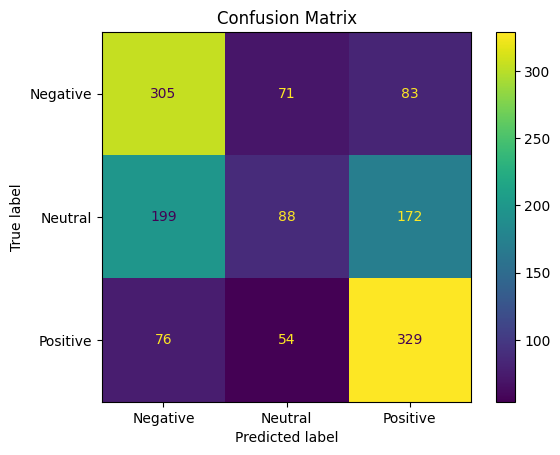

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.53      0.66      0.59       459
     Neutral       0.41      0.19      0.26       459
    Positive       0.56      0.72      0.63       459

    accuracy                           0.52      1377
   macro avg       0.50      0.52      0.49      1377
weighted avg       0.50      0.52      0.49      1377



In [21]:
tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
tri_logreg.fit(tri_train_bow, train_labels)

predictions = tri_logreg.predict(tri_test_bow)
acc_lr_tri_bow = test_statistics(predictions, test_labels)

##### 4.2.3.2 TGIDF

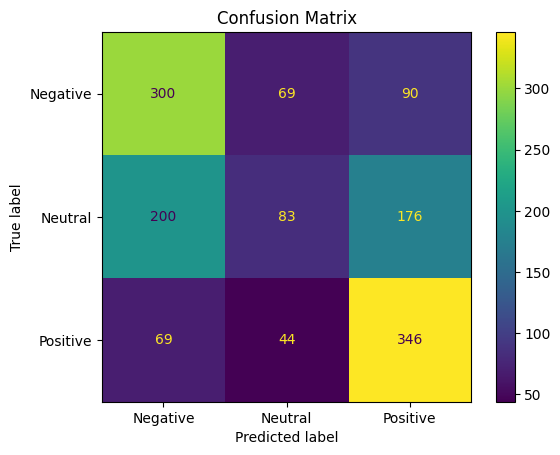

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.53      0.65      0.58       459
     Neutral       0.42      0.18      0.25       459
    Positive       0.57      0.75      0.65       459

    accuracy                           0.53      1377
   macro avg       0.51      0.53      0.49      1377
weighted avg       0.51      0.53      0.49      1377



In [22]:
tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
tri_logreg.fit(tri_train_tgidf, train_labels)

predictions = tri_logreg.predict(tri_test_tgidf)
acc_lr_tri_tg = test_statistics(predictions, test_labels)

### 4.3 Linear Support Vector Machine (LSVM) 
#### 4.3.1. Unigram 

##### 4.3.1.1 Bag-of-Words

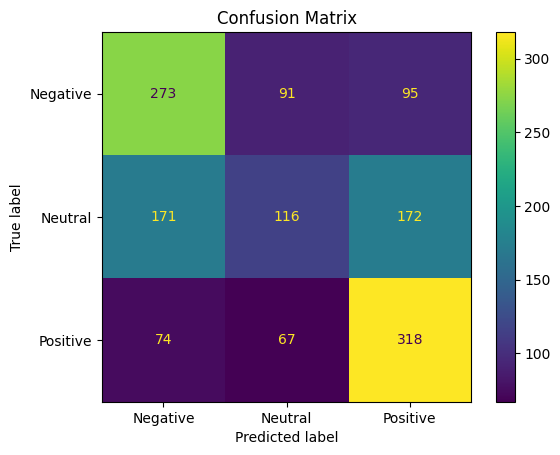

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.53      0.59      0.56       459
     Neutral       0.42      0.25      0.32       459
    Positive       0.54      0.69      0.61       459

    accuracy                           0.51      1377
   macro avg       0.50      0.51      0.49      1377
weighted avg       0.50      0.51      0.49      1377



In [23]:
uni_lsvm = sklearn.svm.LinearSVC()
uni_lsvm.fit(uni_train_bow, train_labels)
 
predictions = uni_lsvm.predict(uni_test_bow)
acc_ls_uni_bow = test_statistics(predictions, test_labels)

##### 4.3.1.2 TGIDF

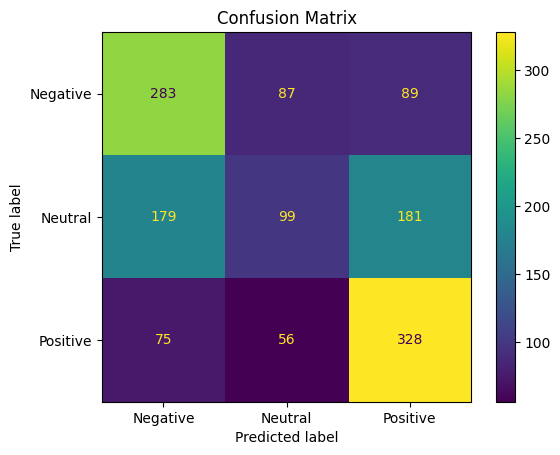

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.53      0.62      0.57       459
     Neutral       0.41      0.22      0.28       459
    Positive       0.55      0.71      0.62       459

    accuracy                           0.52      1377
   macro avg       0.49      0.52      0.49      1377
weighted avg       0.49      0.52      0.49      1377



In [24]:
uni_lsvm = sklearn.svm.LinearSVC()
uni_lsvm.fit(uni_train_tgidf, train_labels)
 
predictions = uni_lsvm.predict(uni_test_tgidf)
acc_ls_uni_tg = test_statistics(predictions, test_labels)

#### 4.3.2. LSVM: Unigram + Bigram 

##### 4.3.2.1 Bag-of-Words

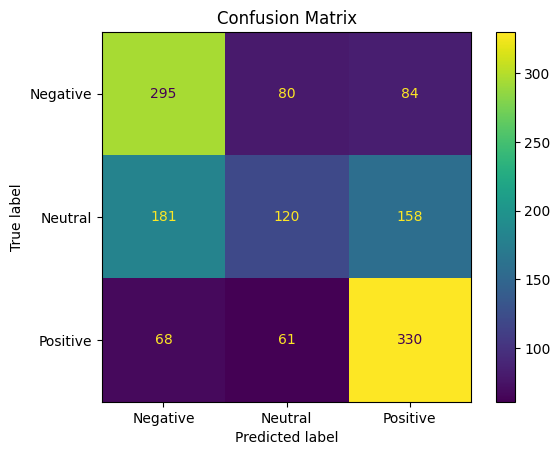

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.64      0.59       459
     Neutral       0.46      0.26      0.33       459
    Positive       0.58      0.72      0.64       459

    accuracy                           0.54      1377
   macro avg       0.53      0.54      0.52      1377
weighted avg       0.53      0.54      0.52      1377



In [25]:
bi_lsvm = sklearn.svm.LinearSVC()
bi_lsvm.fit(bi_train_bow, train_labels)
 
predictions = bi_lsvm.predict(bi_test_bow)
acc_ls_bi_bow = test_statistics(predictions, test_labels)

##### 4.3.2.2 TGIDF

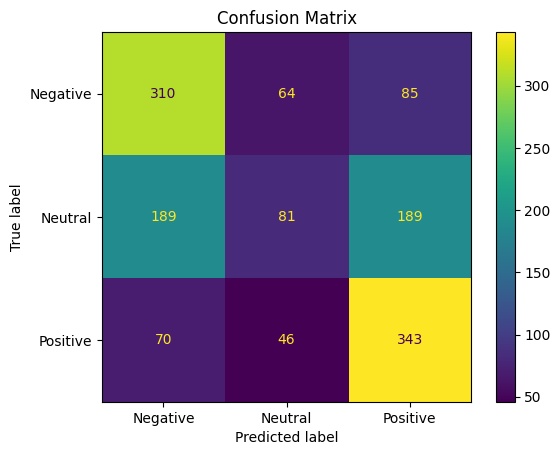

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.68      0.60       459
     Neutral       0.42      0.18      0.25       459
    Positive       0.56      0.75      0.64       459

    accuracy                           0.53      1377
   macro avg       0.51      0.53      0.50      1377
weighted avg       0.51      0.53      0.50      1377



In [26]:
bi_lsvm = sklearn.svm.LinearSVC()
bi_lsvm.fit(bi_train_tgidf, train_labels)
 
predictions = bi_lsvm.predict(bi_test_tgidf)
acc_ls_bi_tg = test_statistics(predictions, test_labels)

#### 4.3.3. LSVM: Unigram + Bigram + Trigram

##### 4.3.3.1 Bag-of-Words

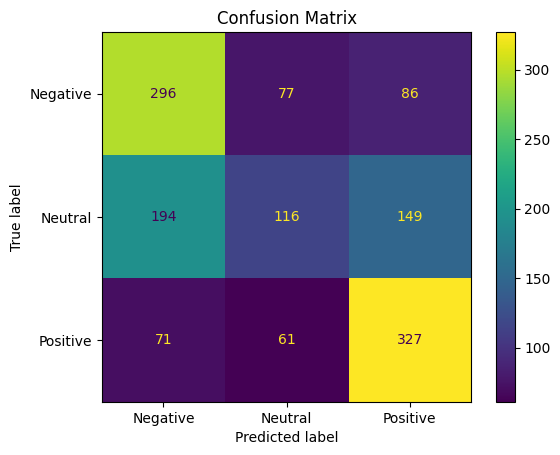

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.53      0.64      0.58       459
     Neutral       0.46      0.25      0.33       459
    Positive       0.58      0.71      0.64       459

    accuracy                           0.54      1377
   macro avg       0.52      0.54      0.52      1377
weighted avg       0.52      0.54      0.52      1377



In [27]:
tri_lsvm = sklearn.svm.LinearSVC()
tri_lsvm.fit(tri_train_bow, train_labels)
 
predictions = tri_lsvm.predict(tri_test_bow)
acc_ls_tri_bow = test_statistics(predictions, test_labels)

##### 4.3.3.2 TGIDF

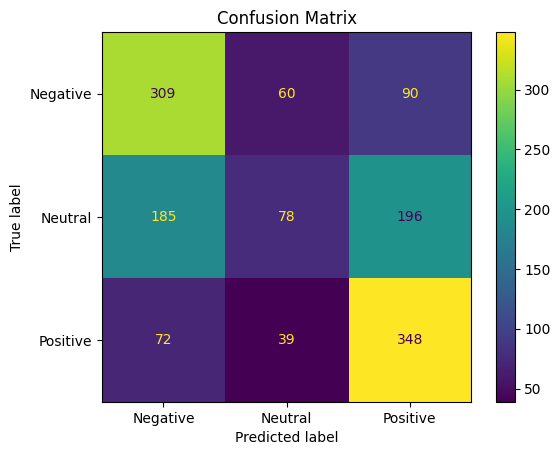

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.67      0.60       459
     Neutral       0.44      0.17      0.25       459
    Positive       0.55      0.76      0.64       459

    accuracy                           0.53      1377
   macro avg       0.51      0.53      0.49      1377
weighted avg       0.51      0.53      0.49      1377



In [28]:
tri_lsvm = sklearn.svm.LinearSVC()
tri_lsvm.fit(tri_train_tgidf, train_labels)
 
predictions = tri_lsvm.predict(tri_test_tgidf)
acc_ls_tri_tg = test_statistics(predictions, test_labels)

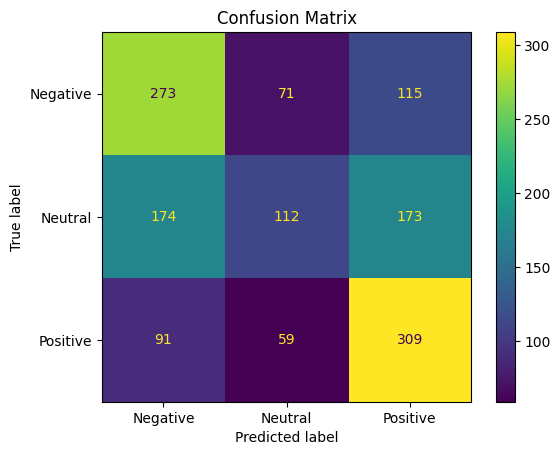

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.51      0.59      0.55       459
     Neutral       0.46      0.24      0.32       459
    Positive       0.52      0.67      0.59       459

    accuracy                           0.50      1377
   macro avg       0.50      0.50      0.48      1377
weighted avg       0.50      0.50      0.48      1377



In [29]:
from sklearn.ensemble import RandomForestClassifier
uni_rf = sklearn.ensemble.RandomForestClassifier()
uni_rf.fit(uni_train_bow, train_labels)
 
predictions = uni_rf.predict(uni_test_bow)
acc_rf_uni_bow = test_statistics(predictions, test_labels)

## 5. Ergebnisse vergleichen

Der Multinomial Naive Bayes Algorithmus erzielt auf unserem Movie-Review Datensatz die besten Ergebnisse.  
Trotz der verletzten Annahme: Unabhängigkeit zwischen den einzelnen Features, funktioniert dieser Algorithmus am besten von den klassischen Modellen.  

Zwischen den N-Grams gibt es dabei kaum unterschiede in der Accuracy.  
Die Bi- und Trigrams enthalten mehr Informationen, als das Uni-Gram, daher liefern diese auch erwartungsgemäß eine leicht bessere Accuracy.  
Kommentare wie z.B. "nicht gut" können bei den Bi- und Trigramms ebenfalls erfasst werden, bei den Unigrams würden "nicht" und "gut" einzeln gezählt werden und nicht mehr im direkten Zusammenhang stehen.  
Der Unterschied liegt allerdings bei unter 1%.  

Überraschend hingegen ist die Erkenntnis, dass TGIDF auf den Movie-Review Daten keine besseren Ergebnisse liefert als der Bag-of-Words Ansantz.  
Die inverse document frequency scheint bei der Sentiment Analyse keine große Rolle zu spielen.  

### 5.1. Bag-of-Words Ergebnisse

In [30]:
mr_bow = {'Naive Bayes': [acc_nb_uni_bow, acc_nb_bi_bow, acc_nb_tri_bow], 'Log Regression': [acc_lr_uni_bow, acc_lr_bi_bow, acc_lr_tri_bow], 'LSVM': [acc_ls_uni_bow, acc_ls_bi_bow, acc_ls_tri_bow]}
df_mr_bow = pd.DataFrame((mr_bow), ['Uni-gram', 'Bi-gram', 'Tri-gram'], ['Naive Bayes', 'Log Regression', 'LSVM'])
print(df_mr_bow)

          Naive Bayes  Log Regression      LSVM
Uni-gram     0.538853        0.520697  0.513435
Bi-gram      0.545389        0.532317  0.541031
Tri-gram     0.545389        0.524328  0.536674


### 5.2. TGIDF Ergebnisse

In [31]:
mr_tgidf = {'Naive Bayes': [acc_nb_uni_tg, acc_nb_bi_tg, acc_nb_tri_tg], 'Log Regression': [acc_lr_uni_tg, acc_lr_bi_tg, acc_lr_tri_tg], 'LSVM': [acc_ls_uni_tg, acc_ls_bi_tg, acc_ls_tri_tg]}
df_mr_tgidf = pd.DataFrame((mr_tgidf), ['Uni-gram', 'Bi-gram', 'Tri-gram'], ['Naive Bayes', 'Log Regression', 'LSVM'])
print(df_mr_tgidf)

          Naive Bayes  Log Regression      LSVM
Uni-gram     0.535221        0.529412  0.515614
Bi-gram      0.542484        0.522150  0.533043
Tri-gram     0.543936        0.529412  0.533769


## Tweets (größeres Daten-Set)
- 1,6 mio Samples (nach Balancing)
- 2 Klassen: -1: negativ, 1: positiv
  
Wir haben hier den gleichen Code angewandt, wie bei dem kleineren Datensatz, daher ist unser Vorgehen nicht noch einmal beschrieben

In [102]:
train_set = pd.read_csv ("data/dataset_tw/Trainset_complete.csv", sep = ';')
test_set = pd.read_csv ("data/dataset_tw/Testset.csv", sep = ';')

In [103]:
# Daten um NaNs bereinigen 
train_set.dropna()

# Sicherstellen, dass in "Phrase" nur strings stehen, damit Daten weiterverarbeitet werden können
train_set['Phrase'] = train_set['Phrase'].astype(str)

In [105]:
import nltk
# nltk.download('stopwords')
# pip install nltk
import re

# Zeitbedarf: 7m 14s


# Für Sentimentanalyse zählen nur Wörter  
def keep_only_letters(text):
    text=re.sub(r'[^a-zA-Z\s]','',text)
    return text
 
# Groß- und Kleinschreibung egal 
def convert_to_lowercase(text):
    return text.lower()
 
def clean_reviews(text):
    text = keep_only_letters(text)
    text = convert_to_lowercase(text)
    return text


# Stop Words definition
english_stop_words = nltk.corpus.stopwords.words('english')

# Stop Words removal
def remove_stop_words(text):
    for stopword in english_stop_words:
        stopword = ' ' + stopword + ' '
        text = text.replace(stopword, ' ')
    return text


# Stemming
def text_stemming(text):
    stemmer = nltk.porter.PorterStemmer()
    stemmed = ' '.join([stemmer.stem(token) for token in text.split()])
    return stemmed


train_set['Phrase'] = train_set['Phrase'].apply(clean_reviews)
test_set['Phrase'] = test_set['Phrase'].apply(clean_reviews)

train_set['Phrase'] = train_set['Phrase'].apply(remove_stop_words)
test_set['Phrase'] = test_set['Phrase'].apply(remove_stop_words)

train_set['Phrase'] = train_set['Phrase'].apply(text_stemming) 
test_set['Phrase'] = test_set['Phrase'].apply(text_stemming)

## 3. Text Vectorization

In [106]:
# convert text data to numeric

# Vectorizer für Bag-of-Word
# Unigram
vectorizer_uni_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))
# Bigram
vectorizer_bi_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,2))
# Trigram
vectorizer_tri_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,3))


In [107]:
# Vectorizer für TGIDF
# Unigram
vectorizer_uni_tgidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,1))
# Bigram
vectorizer_bi_tgidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,2))
# Trigram
vectorizer_tri_tgidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,3))

In [108]:
# Dauer mit Cleaning: 3m 24s 
# Dauer ohne Cleaning: 4m 46s 

uni_train_bow = vectorizer_uni_bow.fit_transform(train_set['Phrase'])
uni_test_bow = vectorizer_uni_bow.transform(test_set['Phrase'])
#print (uni_features_train.shape, uni_features_test.shape)

bi_train_bow = vectorizer_bi_bow.fit_transform(train_set['Phrase'])
bi_test_bow = vectorizer_bi_bow.transform(test_set['Phrase'])
#print (bi_features_train.shape, bi_features_test.shape)

tri_train_bow = vectorizer_tri_bow.fit_transform(train_set['Phrase'])
tri_test_bow = vectorizer_tri_bow.transform(test_set['Phrase'])
#print (tri_features_train.shape, tri_features_test.shape)

In [109]:
# Vectorizer auf das Train-Set fitten und damit Train- und Test-Set transformieren - TGIDF

uni_train_tgidf = vectorizer_uni_tgidf.fit_transform(train_set['Phrase'])
uni_test_tgidf = vectorizer_uni_tgidf.transform(test_set['Phrase'])

bi_train_tgidf = vectorizer_bi_tgidf.fit_transform(train_set['Phrase'])
bi_test_tgidf= vectorizer_bi_tgidf.transform(test_set['Phrase'])

tri_train_tgidf = vectorizer_tri_tgidf.fit_transform(train_set['Phrase'])
tri_test_tgidf = vectorizer_tri_tgidf.transform(test_set['Phrase'])

In [118]:
train_labels = train_set['Sentiment']
test_labels = test_set['Sentiment']
train_labels=train_labels.astype(str)
test_labels=test_labels.astype(str)

## 4. Klassifizierungsmodelle trainieren

In [119]:
from sklearn import metrics
from sklearn.utils.extmath import density
from time import time

def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(tri_train_tgidf, train_labels)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(tri_test_tgidf)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    score = metrics.accuracy_score(test_labels, pred)
    print(f"accuracy:   {score:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score, train_time, test_time

In [120]:
# diverse Modelle testen, die 3 mit bester Accuracy verfolgen wir weiter

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC

results = []
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    # L2 penalty Linear SVC
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
   
    # NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "NearestCentroid"),
    # naive Bayes classifier
    (MultinomialNB(), "Multinomial naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=5, max_iter=1000)


### 4.1.  Naive Bayes

In [ ]:
# Naive Bayes Unigram 
# mit Cleaning: Zeit: 2s Accuracy: 0.77
# ohne Cleaning: Zeit: 2s Accuracy: 0.78

from sklearn.naive_bayes import MultinomialNB

uni_nb = MultinomialNB()
uni_nb.fit(uni_train_bow, train_labels)
 
predictions = uni_nb.predict(uni_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','1']))

In [ ]:
# Naive Bayes Unigram + Bigram
# mit Cleaning: Zeit: 6.5s Accuracy: 0.78
# ohne Cleaning: Zeit: 6.5s Accuracy: 0.80

bi_nb = MultinomialNB()
bi_nb.fit(bi_train_bow, train_labels)
 
predictions = bi_nb.predict(bi_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))


In [ ]:
# Naive Bayes Unigram + Bigram + Trigram
# mit Cleaning: Zeit: 4.2s Accuracy: 0.79
# mit Cleaning: Zeit: 4.2s Accuracy: 0.80

tri_nb = MultinomialNB()
tri_nb.fit(tri_train_bow, train_labels)
 
predictions = tri_nb.predict(tri_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))


### 4.2 Logistische Regression

In [ ]:
# Logistische Regression Unigram
# mit Cleaning: Zeit: 5m 50s Accuracy: 0.78
# ohne Cleaning: Zeit: 7m 26s Accuracy: 0.80


uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
uni_logreg.fit(uni_train_bow, train_labels)

predictions = uni_logreg.predict(uni_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))


In [ ]:
# Logistische Regression Unigram + Bigram
# mit Cleaning: Zeit: 20m 7s Accuracy: 0.80 


bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
bi_logreg.fit(bi_train_bow, train_labels)
#print (bi_logreg)

predictions = bi_logreg.predict(bi_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))
# Feature-Set Größe erhöht sich weil auch Bi-Gramme berücksichtigt 

In [ ]:
# Logistische Regression Unigram + Bigram + Trigram
# mit Cleaning: Zeit: 36m 21s Accuracy: 0.80 

tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
tri_logreg.fit(tri_train_bow, train_labels)
#print (tri_logreg)

predictions = tri_logreg.predict(tri_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))

### 4.3 Linear Support Vector Machine (LSVM) 

In [ ]:
# Linear Support Vector Machine (LSVM) Unigram
# mit Cleaning: Zeit: 10m 12s Accuracy: 0.77 

uni_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
uni_lsvm.fit(uni_train_bow, train_labels)
 
predictions = uni_lsvm.predict(uni_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))

In [ ]:
# Linear Support Vector Machine (LSVM) Unigram + Bigram
# mit Cleaning: Zeit: 11m 30s Accuracy: 0.79 

bi_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
bi_lsvm.fit(bi_train_bow, train_labels)
 
predictions = bi_lsvm.predict(bi_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))

In [ ]:
# Linear Support Vector Machine (LSVM) Unigram + Bigram + Trigram
# mit Cleaning: Zeit: 13m 10s Accuracy: 0.79

tri_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
tri_lsvm.fit(tri_train_bow, train_labels)
 
predictions = tri_lsvm.predict(tri_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))

### 5.1. Bag-of-Words Ergebnisse

In [ ]:
mr_bow = {'Naive Bayes': [acc_nb_uni_bow, acc_nb_bi_bow, acc_nb_tri_bow], 'Log Regression': [acc_lr_uni_bow, acc_lr_bi_bow, acc_lr_tri_bow], 'LSVM': [acc_ls_uni_bow, acc_ls_bi_bow, acc_ls_tri_bow]}
df_mr_bow = pd.DataFrame((mr_bow), ['Uni-gram', 'Bi-gram', 'Tri-gram'], ['Naive Bayes', 'Log Regression', 'LSVM'])
print(df_mr_bow)

### 5.2. TGIDF Ergebnisse

In [ ]:
mr_tgidf = {'Naive Bayes': [acc_nb_uni_tg, acc_nb_bi_tg, acc_nb_tri_tg], 'Log Regression': [acc_lr_uni_tg, acc_lr_bi_tg, acc_lr_tri_tg], 'LSVM': [acc_ls_uni_tg, acc_ls_bi_tg, acc_ls_tri_tg]}
df_mr_tgidf = pd.DataFrame((mr_tgidf), ['Uni-gram', 'Bi-gram', 'Tri-gram'], ['Naive Bayes', 'Log Regression', 'LSVM'])
print(df_mr_tgidf)

Quellen: 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
https://scikit-learn.org/stable/modules/naive_bayes.html
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://dropsofai.com/sentiment-analysis-with-python-bag-of-words/
https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

